## Practical Time Series Analysis & Forecast
By: Volker Felvic Katche Tachin

31st January 2023

Note:
- Some answers might appear different from the ones chosen on the time quized, as these new answers were realised after failing some questions on the quiz.
- Also, many scores turned out to be different from those in the quiz answers even after multiple iterations

### Importing Libraries

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from prophet import Prophet
from statsmodels.tsa.stattools import adfuller

### Data Loading & Exploration

In [84]:
df = pd.read_csv('Time_series_analysis_and_forecast_DATASET.csv', parse_dates = ['FullDate'], index_col = 'FullDate')

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 92016 entries, 2010-09-01 00:00:00 to 2021-02-28 23:00:00
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Tmax       92016 non-null  float64
 1   SysLoad    92016 non-null  float64
 2   GasPrice   92016 non-null  float64
 3   ElecPrice  92016 non-null  float64
dtypes: float64(4)
memory usage: 3.5 MB


In [24]:
df.head()

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


#### Plot of Resampled ElecPrice

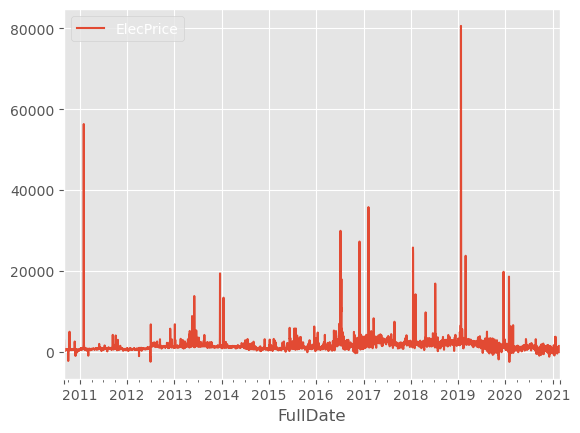

In [148]:
df.resample('D').sum()['ElecPrice'].plot()
plt.legend();

#### ADF Tests

In [119]:
trying = df.resample('D').sum()
print('SysLoad',adfuller(trying['SysLoad']))
print('GasPrice', adfuller(trying['GasPrice']))
print('ElecPrice', adfuller(trying['ElecPrice']))

SysLoad (-3.6901589888366475, 0.004253725504574097, 30, 3803, {'1%': -3.432070672988693, '5%': -2.8623002987378547, '10%': -2.567174716967499}, 79103.01504886392)
GasPrice (-2.9027666971651778, 0.045027212884625675, 27, 3806, {'1%': -3.4320693157877544, '5%': -2.8622996992165364, '10%': -2.5671743978048323}, 32857.5394299048)
ElecPrice (-8.269053866873815, 4.848817773711248e-13, 20, 3813, {'1%': -3.432066157296446, '5%': -2.8622983040036005, '10%': -2.5671736550459663}, 69130.36360776308)


#### Univariate Model

In [85]:
uni_resampled = df.resample('D').sum()
uni_resampled = uni_resampled[['ElecPrice']].copy().reset_index()
uni_resampled.rename(columns = {'FullDate' : 'ds', 'ElecPrice' : 'y'}, inplace = True)
uni_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3834 entries, 0 to 3833
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3834 non-null   datetime64[ns]
 1   y       3834 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 60.0 KB


In [97]:
uni_train = uni_resampled.iloc[:2757, :]
X_test_uni = uni_resampled.iloc[2757: , :].drop(columns = 'y')
y_test_uni = uni_resampled.iloc[2757: , -1].values

In [88]:
uni_model = Prophet()
uni_model.fit(uni_train)

00:17:23 - cmdstanpy - INFO - Chain [1] start processing
00:17:24 - cmdstanpy - INFO - Chain [1] done processing


In [89]:
uni_forecast = uni_model.predict(X_test_uni)
uni_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1072,2021-02-24,3420.990463,440.075213,6296.079986
1073,2021-02-25,3487.847025,423.192577,6568.030988
1074,2021-02-26,3254.630100,256.649475,6216.314487
1075,2021-02-27,2911.256585,-136.179443,5955.725973
1076,2021-02-28,2823.176966,-152.825341,5989.919679


##### Functions to calculate MAPE and RMSE

In [150]:
def mape(preds, actual):
    result = np.mean(np.abs((actual - preds) / actual)) * 100
    return result


def rootmse(preds, actual):
    result = np.sqrt(np.mean((actual - preds) ** 2))
    return result

In [149]:
print('MAPE:', mape(uni_forecast['yhat'].values, y_test_uni))
print('RMSE:', rootmse(uni_forecast['yhat'].values, y_test_uni))

MAPE: 540.8215054992064
RMSE: 3200.059470484567


In [ ]:
fig1 = uni_model.plot(uni_forecast)

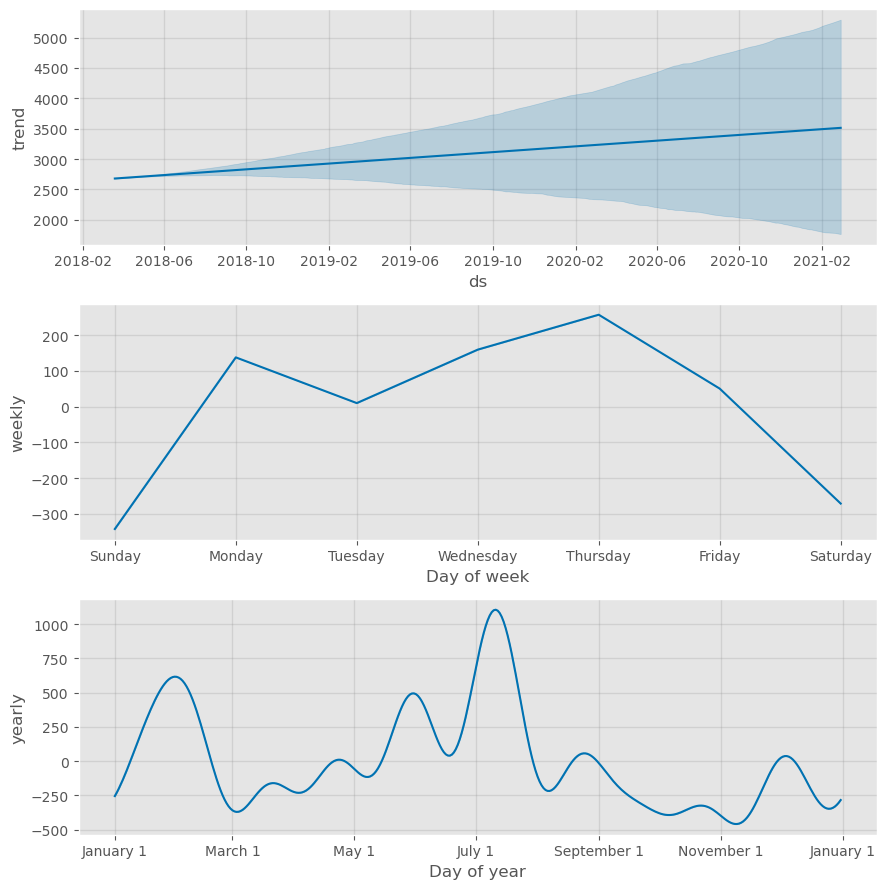

In [127]:
fig2 = uni_model.plot_components(uni_forecast)

### Multivariate Model

In [132]:
multi_resampled = df.resample('D').sum()
multi_resampled = multi_resampled.copy().reset_index()
multi_resampled.rename(columns = {'FullDate' : 'ds', 'SysLoad' : 'add1', 'Tmax' : 'add2', 'GasPrice' : 'add3', 'ElecPrice' : 'y'}, inplace = True)
multi_resampled.info()

multi_train = multi_resampled.iloc[:2757, :]
X_test_multi = multi_resampled.iloc[2757:, :].drop(columns = 'y')
y_test_multi = multi_resampled.iloc[2757:, -1].values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3834 entries, 0 to 3833
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3834 non-null   datetime64[ns]
 1   add2    3834 non-null   float64       
 2   add1    3834 non-null   float64       
 3   add3    3834 non-null   float64       
 4   y       3834 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 149.9 KB


In [136]:
multi_model = Prophet()
multi_model.add_regressor('add1')
multi_model.add_regressor('add2')
multi_model.add_regressor('add3')
multi_model.fit(multi_train)

multi_forecast = multi_model.predict(X_test_multi)

13:35:13 - cmdstanpy - INFO - Chain [1] start processing
13:35:15 - cmdstanpy - INFO - Chain [1] done processing


In [137]:
multi_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1072,2021-02-24,962.638761,-1451.992413,3287.193893
1073,2021-02-25,1322.256687,-1011.477090,3575.192080
1074,2021-02-26,1386.095390,-1034.238884,3661.575701
1075,2021-02-27,1040.925982,-1396.827115,3290.582943
1076,2021-02-28,1201.326413,-1112.901472,3431.036232


In [151]:
print('MAPE:', mape(multi_forecast['yhat'].values, y_test_multi))
print('RMSE', rootmse(multi_forecast['yhat'].values, y_test_multi))

MAPE: 232.71577777254845
RMSE 2708.483824143241


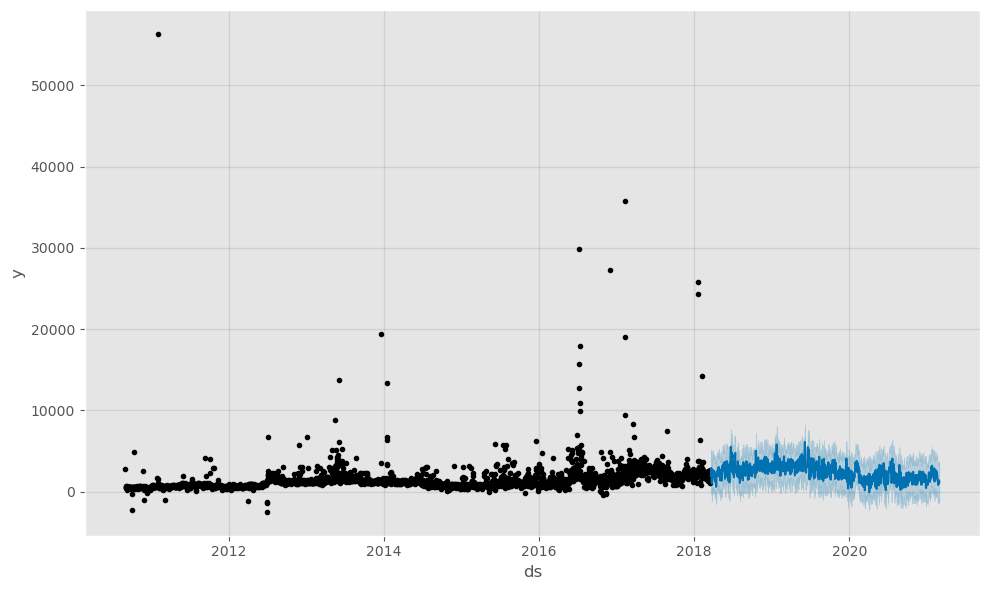

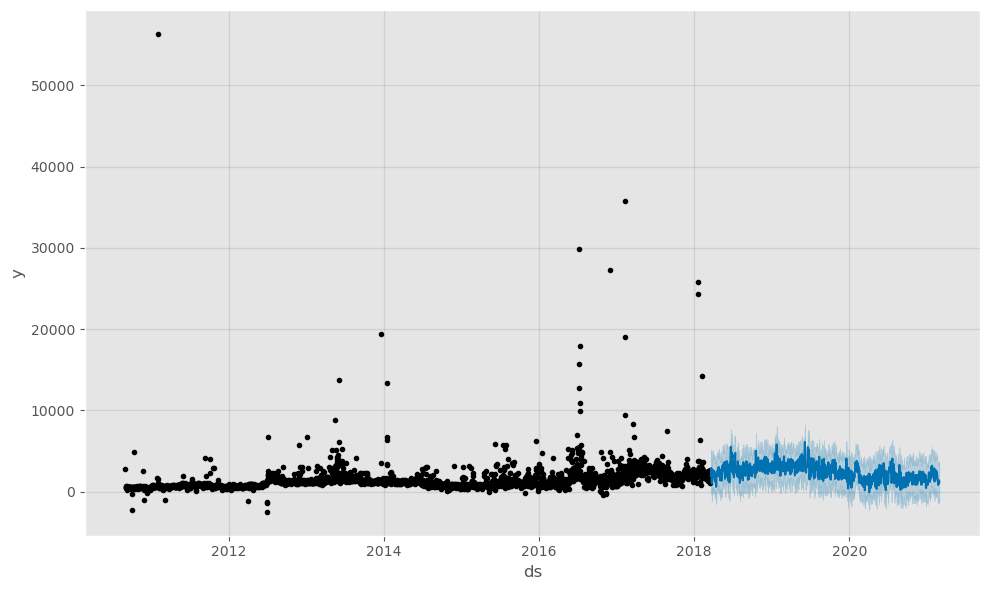

In [95]:
multi_model.plot(multi_forecast)

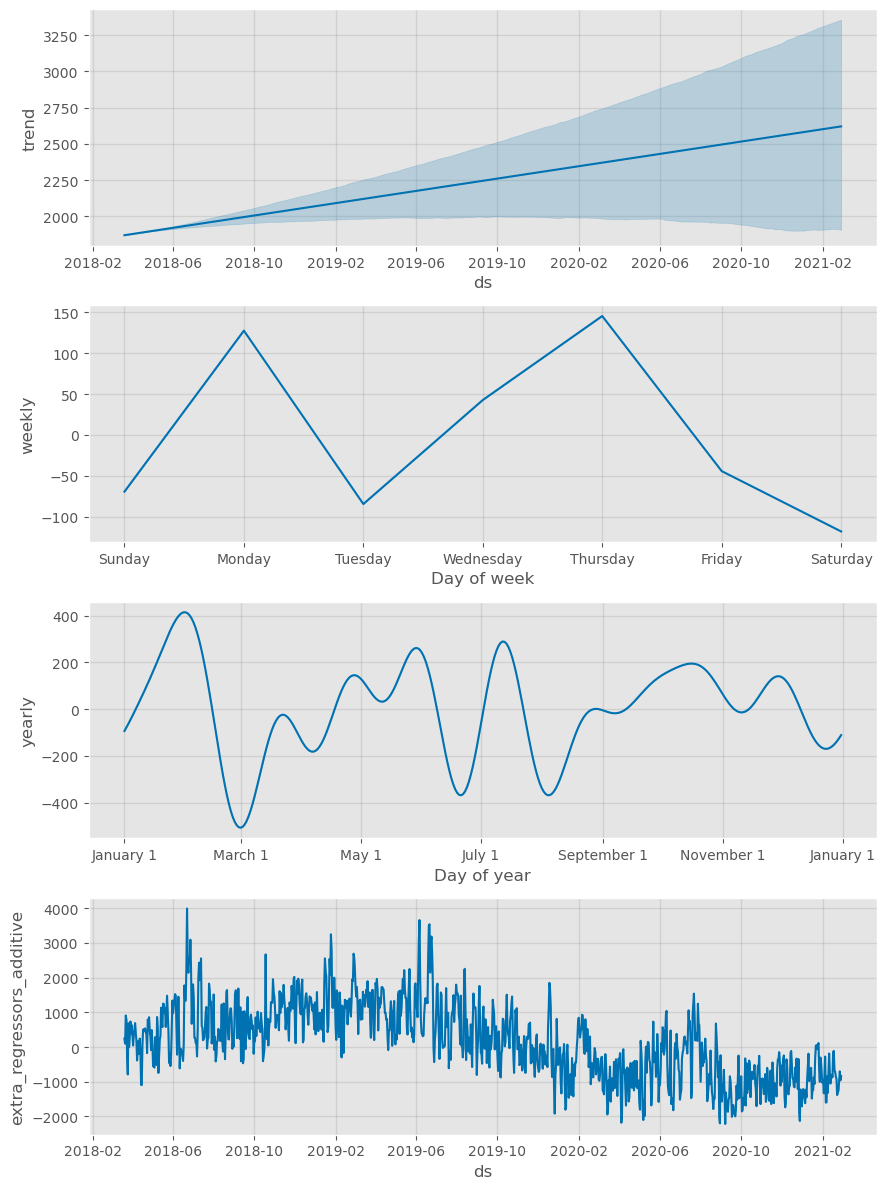

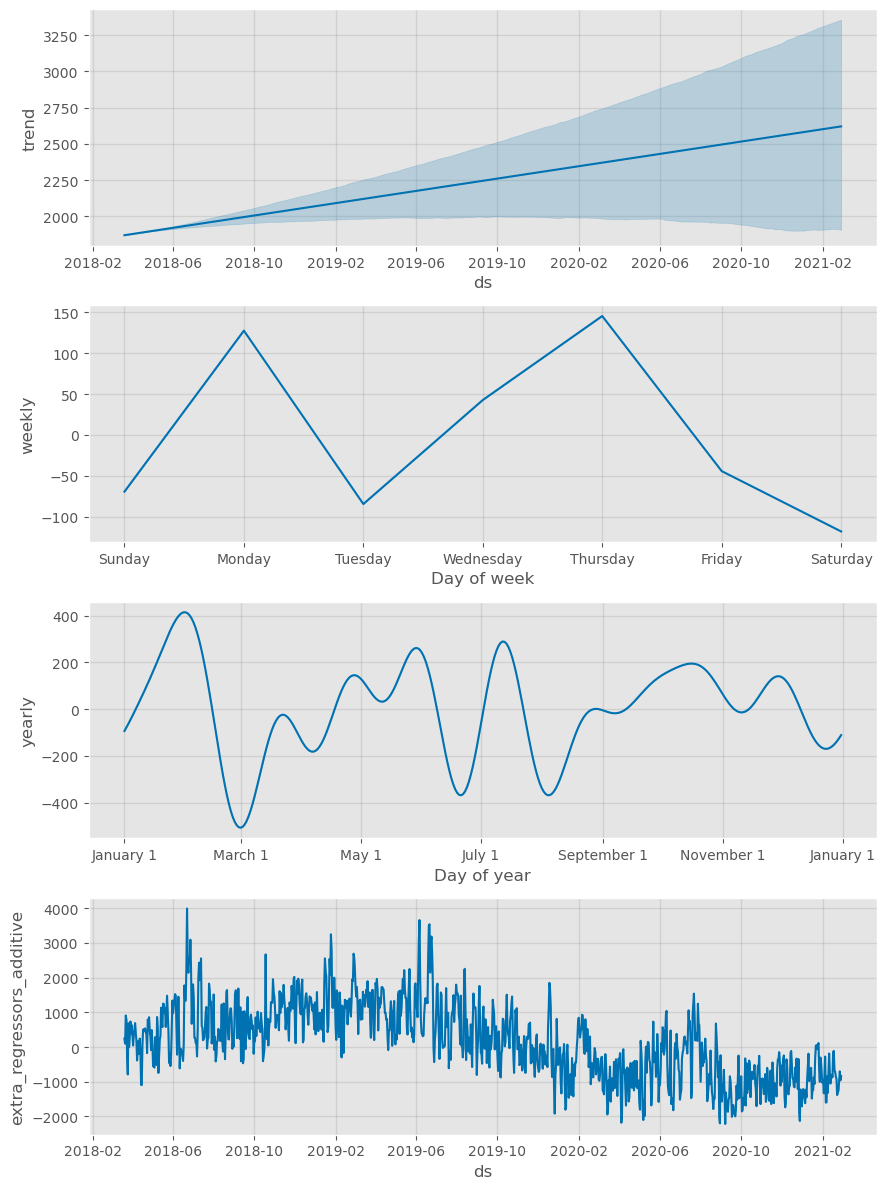

In [131]:
multi_model.plot_components(multi_forecast)

### Last Model (Without Tmax)

In [139]:
new_resampled = df.resample('D').sum()
new_resampled = new_resampled[['SysLoad', 'GasPrice', 'ElecPrice']].copy().reset_index()
new_resampled.rename(columns = {'FullDate' : 'ds', 'SysLoad' : 'add1', 'GasPrice' : 'add2', 'ElecPrice' : 'y'}, inplace = True)
new_resampled.info()

new_train = new_resampled.iloc[:2757, :]
X_test_new = new_resampled.iloc[2757:, :].drop(columns = 'y')
y_test_new = new_resampled.iloc[2757:, -1].values


new_model = Prophet()
new_model.add_regressor('add1')
new_model.add_regressor('add2')
new_model.fit(new_train)

new_forecast = new_model.predict(X_test_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3834 entries, 0 to 3833
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3834 non-null   datetime64[ns]
 1   add1    3834 non-null   float64       
 2   add2    3834 non-null   float64       
 3   y       3834 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 119.9 KB


13:36:12 - cmdstanpy - INFO - Chain [1] start processing
13:36:12 - cmdstanpy - INFO - Chain [1] done processing


In [152]:
print('MAPE:', mape(new_forecast['yhat'].values, y_test_new))

MAPE: 233.69864620672578
